In [1]:
from collections import Counter

import pandas as pd


In [2]:
vcf_file = "variants.vcf.gz"
vcf_file1 = "GAsP_1163Samples.SNVs.Feb2020.vcf.gz"

vcf_file2 = r"I:\Genomic Project\GAsP_1163Samples.InDels.Feb2020.vcf.gz"
vcf_file3 = r"D:\genome_asia_main_file\genome_asia_data_working\T2T\T2T_SNP_MAF_0.05_Microhap.csv"


In [6]:
def get_vcf_header(vcf_file_input):
    import gzip
    header_line = ""
    # set the opener if it is gzip
    opener = gzip.open if vcf_file_input.endswith(".gz") else open
    # open the file and find the header line
    with opener(vcf_file_input, "rt") as file:
        for line in file:
            if line.startswith("#CHROM"):
                header_line = line
                break
            elif not line.startswith("#"):
                break
    # format the header line to a list
    #format
    if header_line:
        header_columns = header_line.strip("#").strip("\n").split("\t")
        return header_columns
    else:
        return "Unable to find the header"

fixed_columns = get_vcf_header(vcf_file3)  # change file name here >>
print(f"These are the columns found :\n{fixed_columns}\n")



These are the columns found :
Unable to find the header



In [7]:

            #df = pd.read_csv(vcf_file3, sep='\t', comment='#', names=fixed_columns)
#if csv file, uncomment below and comment above
df = pd.read_csv(vcf_file3, sep=",")

df.head(5)



,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,MAF
0,chrY,5690,rs1433259728,T,A,.,PASS,"COMMON;FREQ=dbGaP_PopFreq:0.5563,0.4437;GNO;RS...",0.44370
1,chrY,5733,rs1480643335,G,"A,C",.,PASS,"COMMON;FREQ=GnomAD:0.9656,.,0.03437|dbGaP_PopF...",0.07160
2,chrY,5805,rs1324317743,A,G,.,PASS,"COMMON;FREQ=GnomAD:0.9066,0.09343|dbGaP_PopFre...",0.09004
3,chrY,5807,rs1285314756,T,C,.,PASS,"COMMON;FREQ=GnomAD:0.9107,0.08932|dbGaP_PopFre...",0.08970
4,chrY,5836,rs1188128742,A,"C,G",.,PASS,"COMMON;FREQ=GnomAD:0.2337,0.7663,.|dbGaP_PopFr...",0.26060


## T2T calculation logic to find MAF

In [ ]:
# Finding MAF and writing in standard format to INFO column
import re

# FREQ=dbGaP_PopFreq:1,0;GNO;RS=2068592700;SSR=0;VC=DEL
expression=r"dbGaP_PopFreq:([^;]+)"

def extract_maf(row):
    if 'dbGaP_PopFreq:' in row:
        for part in row.split(';'):
            match=re.search(expression, part)
            if match:
                values = match.group(1).split(',')
                try:
                    # listing all the ALT freq
                    alt_freqs = [float(v) for v in values if v not in ('.', '0', '1')]
                    #print(alt_freqs)
                    # Find the MAF min of ALT
                    maf = min(alt_freqs)
                    #print(maf)
                    return f"MAF={maf:.6g}"

                except ValueError:
                    pass
    return "MAF=0"

def extract_maf2(row):
    if 'dbGaP_PopFreq:' in row:
        for part in row.split(';'):
            match=re.search(expression, part)
            if match:
                values = match.group(1).split(',')
                try:
                    # listing all the ALT freq
                    alt_freqs = [float(v) for v in values if v not in ('.', '0', '1')]
                    #print(alt_freqs)
                    # Find the MAF min of ALT
                    maf = min(alt_freqs)
                    #print(maf)
                    return maf

                except ValueError:
                    pass

    # if nothing found
    return 0

# Testing
extract_maf("FREQ=dbGaP_PopFreq:1,0;GNO;RS=2068592700;SSR=0;VC=DEL")
extract_maf2("FREQ=dbGaP_PopFreq:1,0;GNO;RS=2068592700;SSR=0;VC=DEL")


In [ ]:
# Apply extract_maf to the INFO col
df['INFO'] = df['INFO'] + ';' + df['INFO'].apply(extract_maf)
# And add a new col
df['MAF'] = df['INFO'].apply(extract_maf2)


In [ ]:
df

In [ ]:
# Main filtering step
filt = df['MAF'] > 0.05
df[filt].tail()

In [ ]:
# File saving to vcf file add the header ##INFO=<ID=MAF,Number=1,Type=Float,Description="Minor Allele Frequency">

# Save to a csv file
df_save = df[filt]
df_save.to_csv(r"D:\genome_asia_main_file\genome_asia_data\T2T\T2T_SNP_MAF_0.05_Microhap.csv", index=False)

In [ ]:
# Make a TXT file to view the POS easily
snp_cluster_list = df['POS'].tolist()
# Code to create bed file to view records using bcftools -R
with open(r"D:\genome_asia_main_file\genome_asia_data_working\T2T\T2T_Y_SNP_B_Microhap_TXT.txt", "wt+") as file:
    for pos in snp_cluster_list:  # looks complex as snp_cluster_list is a [[]]
        file.write(f"chrY\t{pos}\n")
# Use this bcftools view -T T2T_CHROM_Y_SNP_sites.txt input.vcf.gz -Oz -o filtered_snps.vcf.gz


## GAsP calculation logic to find MAF

In [173]:
# # Crafting the logic to put out the AD to AF then to MAF values

  sample_info_str = "GT1168=1:1,0:629,.:533"
sample_data = sample_info_str.split('=')[1]
print(sample_data)
fields = sample_data.split(':')
print(fields)
ad_field = fields[1]
print(f"ad_field = {ad_field}")
ad_values = ad_field.split(',')
print(f"ad_values = {ad_values}")
ad_counts = [int(allele) if allele.isdigit() else 0 for allele in ad_values]
print(f"ad_counts = {ad_counts}")
total_depth = sum(ad_counts)
allele_freqs = [allele/total_depth for allele in ad_counts]
print(f"allele_freqs = {allele_freqs}")
maf = min(allele_freqs)
print(f"maf = {maf}")

1:1,0:629,.:533
['1', '1,0', '629,.', '533']
ad_field = 1,0
ad_values = ['1', '0']
ad_counts = [1, 0]
allele_freqs = [1.0, 0.0]
maf = 0.0


In [174]:
# noinspection PyShadowingNames
def get_maf(sample_info_str):
    try:
        # Crafting the logic to put out the AD to AF then to MAF values
        sample_data = sample_info_str.split('=')[1]
        fields = sample_data.split(':')
        ad_field = fields[1]
        ad_values = ad_field.split(',')
        ad_counts = [int(allele) if allele.isdigit() else 0 for allele in ad_values]
        total_depth = sum(ad_counts)
        allele_freqs = [allele/total_depth for allele in ad_counts]
        maf = min(allele_freqs)
        return maf
    except Exception as e:
        print(f"Error: {e}")
        return None


In [175]:
if df.columns[9] != 'MAF':
    df.insert(9, 'MAF', df['INFO'].apply(get_maf))
df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,MAF,...,GA001885,GA001886,GA001887,GA001888,GA001890,GA001891,GA001892,GA001893,GA001894,GA001895
0,Y,2984956,.,A,"*,C",52936.70,PASS,"GT1168=2:3,1:112,0:393,.:655",GT:AD:DP:GQ:PL,0.250000,...,".:0,0,0:.:.:.","0:3,0,0:3:42:0,42,42","0:3,0,0:3:99:0,111,111","0:1,0,0:1:45:0,45,45",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:2,0,0:2:90:0,90,90","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:."
1,Y,2984958,.,A,"C,*",4390.69,PASS,"GT1168=2:11,1:2,0:529,.:621",GT:AD:DP:GQ:PL,0.083333,...,"0:1,0,0:1:45:0,45,45","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,111,111","0:1,0,0:1:45:0,45,45",".:0,0,0:.:.:.","0:1,0,0:1:37:0,37,37","0:2,0,0:2:90:0,90,90","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:."
2,Y,2984960,.,A,"C,*",3267.29,PASS,"GT1168=1:7,0:536,.:620",GT:AD:DP:GQ:PL,0.000000,...,"0:1,0,0:1:45:0,45,45","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,111,111","0:1,0,0:1:45:0,45,45",".:0,0,0:.:.:.","0:1,0,0:1:42:0,42,42","0:2,0,0:2:90:0,90,90","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:."
3,Y,3320873,.,T,"G,A",2741.70,PASS,"GT1168=2:1,1:3,0:626,.:533",GT:AD:DP:GQ:PL,0.500000,...,"0:3,0,0:3:99:0,104,104","0:4,0,0:4:99:0,135,135","0:3,0,0:3:99:0,99,99","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:.","0:4,0,0:4:99:0,135,135","0:6,0,0:6:99:0,180,180","0:5,0,0:5:99:0,180,180","0:4,0,0:4:99:0,135,135",".:0,0,0:.:.:."
4,Y,3320910,.,C,"*,T",4687.68,PASS,"GT1168=2:2,1:1,0:627,.:533",GT:AD:DP:GQ:PL,0.333333,...,"0:3,0,0:3:99:0,104,104","0:4,0,0:4:99:0,135,135","0:3,0,0:3:99:0,99,99","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:.","0:4,0,0:4:99:0,135,135","0:6,0,0:6:99:0,180,180","0:5,0,0:5:99:0,180,180","0:4,0,0:4:99:0,135,135",".:0,0,0:.:.:."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,Y,58976702,.,C,"A,*",28882.30,PASS,"GT1168=2:60,1:9,0:559,.:535",GT:AD:DP:GQ:PL,0.016393,...,"0:32,0,0:32:99:0,225,225","0:27,0,0:27:99:0,236,236","0:21,0,0:21:99:0,422,422","2:17,0,20:37:76:76,827,0",".:0,0,0:.:.:.","0:23,0,0:23:99:0,114,114","0:29,0,0:29:99:0,282,282","0:32,0,0:32:99:0,457,457","0:14,0,0:14:99:0,131,131",".:0,0,0:.:.:."
317,Y,58976837,rs7474438,T,"C,*",52607.10,PASS,"GT1168=2:1,1:127,0:379,.:656",GT:AD:DP:GQ:PL,0.500000,...,"0:15,0,0:15:99:0,333,333","1:3,4,0:7:8:8,0,143",".:0,0,0:.:.:.",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:23,0,0:23:99:0,114,114","0:14,0,0:14:99:0,245,245","0:17,0,0:17:99:0,290,290","0:15,0,12:27:90:0,675,90",".:0,0,0:.:.:."
318,Y,58978513,rs373317895,A,"T,*",4228.05,PASS,"GT1168=2:12,1:3,0:615,.:533",GT:AD:DP:GQ:PL,0.076923,...,"0:19,0,0:19:99:0,612,612","0:14,0,0:14:99:0,129,129","0:11,0,0:11:99:0,203,203","0:14,0,0:14:99:0,167,167",".:0,0,0:.:.:.","0:11,0,0:25:99:0,458,777","0:13,0,0:13:99:0,122,122","0:21,0,0:21:99:0,411,411","0:16,0,0:16:99:0,399,399",".:0,0,0:.:.:."
319,Y,58978519,rs113301980,T,"C,*",4190.36,PASS,"GT1168=2:12,1:3,0:615,.:533",GT:AD:DP:GQ:PL,0.076923,...,"0:19,0,0:19:99:0,612,612","0:14,0,0:14:99:0,129,129","0:11,0,0:11:99:0,203,203","0:14,0,0:14:99:0,167,167",".:0,0,0:.:.:.","0:11,0,0:25:99:0,458,777","0:13,0,0:13:99:0,122,122","0:21,0,0:21:99:0,411,411","0:16,0,0:16:99:0,399,399",".:0,0,0:.:.:."


In [176]:
df_save = df
df_save.to_csv(r"D:\genome_asia_main_file\genome_asia_data_working\Multiallelic\GAsP_Multiallelic_Y_SNP_Microhap_MAF.csv", index=False)

## Finding haplotype diversity calculation

In [146]:
with open('indian_gaid.txt', 'r') as f:
    l = f.read().splitlines()

indian_gaID = [x for x in df.columns[:2].tolist()+df.columns[9:].tolist() if x in l]


In [147]:
selected_columns = ['CHROM', 'POS'] + indian_gaID  # check the sequence, was causing a lot of errors

In [148]:
df = df[selected_columns]
df

,CHROM,POS,GA000632,GA000633,GA000634,GA000635,GA000636,GA000637,GA000638,GA000639,...,GA001320,GA001321,GA001322,GA001323,GA001890,GA001891,GA001892,GA001893,GA001894,GA001895
0,Y,2984956,".:0,0,0:.:.:.","0:3,0,0:3:45:0,45,45","0:3,0,0:3:99:0,107,107","0:5,0,0:5:99:0,108,108","0:3,0,0:3:99:0,104,104","0:5,0,0:5:99:0,180,180","0:3,0,0:3:99:0,127,127","0:7,0,0:7:99:0,180,180",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:4,0,0:4:99:0,105,105",".:0,0,0:.:.:.",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:2,0,0:2:90:0,90,90","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:."
1,Y,2984958,".:0,0,0:.:.:.","0:3,0,0:3:45:0,45,45","0:3,0,0:3:99:0,107,107","0:5,0,0:5:99:0,108,108","0:3,0,0:3:99:0,104,104","0:5,0,0:5:99:0,180,180","0:3,0,0:3:99:0,127,127","0:7,0,0:7:99:0,180,180",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:4,0,0:4:99:0,105,105",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:1,0,0:1:37:0,37,37","0:2,0,0:2:90:0,90,90","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:."
2,Y,2984960,".:0,0,0:.:.:.","0:2,0,0:2:87:0,87,87","0:3,0,0:3:99:0,107,107","0:5,0,0:5:99:0,108,108","0:3,0,0:3:99:0,104,104","0:5,0,0:5:99:0,180,180","0:3,0,0:3:99:0,127,127","0:7,0,0:7:99:0,180,180",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:4,0,0:4:99:0,105,105",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:1,0,0:1:42:0,42,42","0:2,0,0:2:90:0,90,90","0:1,0,0:1:45:0,45,45","0:3,0,0:3:99:0,123,123",".:0,0,0:.:.:."
3,Y,3320873,".:0,0,0:.:.:.","0:4,0,0:4:99:0,135,135","0:3,0,0:3:99:0,118,118","0:3,0,0:3:99:0,120,120","0:3,0,0:3:99:0,121,121","0:3,0,0:3:99:0,118,118","0:4,0,0:4:99:0,135,135","0:4,0,0:4:99:0,135,135",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:3,0,0:3:99:0,109,109",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:4,0,0:4:99:0,135,135","0:6,0,0:6:99:0,180,180","0:5,0,0:5:99:0,180,180","0:4,0,0:4:99:0,135,135",".:0,0,0:.:.:."
4,Y,3320910,".:0,0,0:.:.:.","0:4,0,0:4:99:0,135,135","0:3,0,0:3:99:0,118,118","0:3,0,0:3:99:0,120,120","0:3,0,0:3:99:0,121,121","0:3,0,0:3:99:0,118,118","0:4,0,0:4:99:0,135,135","0:4,0,0:4:99:0,135,135",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:3,0,0:3:99:0,109,109",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:4,0,0:4:99:0,135,135","0:6,0,0:6:99:0,180,180","0:5,0,0:5:99:0,180,180","0:4,0,0:4:99:0,135,135",".:0,0,0:.:.:."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,Y,58976702,".:0,0,0:.:.:.","0:78,0,0:78:99:0,1541,1541","0:46,0,0:46:99:0,910,910","0:64,0,0:64:99:0,1523,1523","0:50,0,0:50:99:0,1579,1579","0:46,0,0:46:99:0,361,361","0:33,0,0:33:99:0,684,684","0:41,0,0:41:99:0,412,412",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","2:20,0,28:48:99:332,1197,0",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:23,0,0:23:99:0,114,114","0:29,0,0:29:99:0,282,282","0:32,0,0:32:99:0,457,457","0:14,0,0:14:99:0,131,131",".:0,0,0:.:.:."
317,Y,58976837,".:0,0,0:.:.:.","0:78,0,0:78:99:0,1541,1541","0:46,0,0:46:99:0,910,910","0:64,0,0:64:99:0,1523,1523","0:50,0,0:50:99:0,1579,1579","0:46,0,0:46:99:0,361,361","0:33,0,0:33:99:0,684,684","0:41,0,0:41:99:0,412,412",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:11,0,0:11:99:0,270,270",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:23,0,0:23:99:0,114,114","0:14,0,0:14:99:0,245,245","0:17,0,0:17:99:0,290,290","0:15,0,12:27:90:0,675,90",".:0,0,0:.:.:."
318,Y,58978513,".:0,0,0:.:.:.","0:33,0,0:33:99:0,945,945","0:18,0,0:18:99:0,315,315","0:29,0,0:29:99:0,585,585","0:22,0,0:22:99:0,630,630","0:25,0,0:25:99:0,810,810","0:18,0,0:18:99:0,450,450","0:23,0,0:23:99:0,540,540",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:11,0,0:11:99:0,103,103",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:11,0,0:25:99:0,458,777","0:13,0,0:13:99:0,122,122","0:21,0,0:21:99:0,411,411","0:16,0,0:16:99:0,399,399",".:0,0,0:.:.:."
319,Y,58978519,".:0,0,0:.:.:.","0:33,0,0:33:99:0,945,945","0:18,0,0:18:99:0,315,315","0:29,0,0:29:99:0,585,585","0:22,0,0:22:99:0,630,630","0:25,0,0:25:99:0,810,810","0:18,0,0:18:99:0,450,450","0:23,0,0:23:99:0,540,540",...,".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:11,0,0:11:99:0,103,103",".:0,0,0:.:.:.",".:0,0,0:.:.:.","0:11,0,0:25:99:0,458,777","0:13,0,0:13:99:0,122,122","0:21,

In [140]:
def extract_gt(field):
    if field == '.' or field == "./." or field.startswith('.:'):
        return 'N'  # missing
    data = field.split(':')[0]
    return data

df_to_map = df[df.columns[2:]]
gt_matrix = df_to_map.applymap(extract_gt)
gt_matrix.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_24392\219939641.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gt_matrix = df_to_map.applymap(extract_gt)


,GA000639,GA000640,GA000641,GA000642,GA000781,GA000782,GA000783,GA000784,GA000785,GA000786,...,GA001320,GA001321,GA001322,GA001323,GA001890,GA001891,GA001892,GA001893,GA001894,GA001895
0,0,N,N,N,N,0,N,N,1,N,...,N,N,0,N,N,N,0,0,0,N
1,0,N,N,N,N,0,N,N,2,N,...,N,N,0,N,N,0,0,0,0,N
2,0,N,N,N,N,0,N,N,0,N,...,N,N,0,N,N,0,0,0,0,N
3,0,N,N,N,N,0,N,N,0,N,...,N,N,0,N,N,0,0,0,0,N
4,0,N,N,N,N,0,N,N,0,N,...,N,N,0,N,N,0,0,0,0,N


In [141]:
# Now create haplotypes per sample
haplotypes = {}
for sample in gt_matrix.columns:
    h1 = ""
    h2 = ""
    for gt in gt_matrix[sample]:
        if "|" in gt:
            a1, a2 = gt.split("|")
        elif "/" in gt:
            a1, a2 = gt.split("/")
        elif gt in ["0", "1"]:
            # Assume homozygous if only one allele
            a1 = a2 = gt
        else:
            a1 = a2 = "N"
        h1 += a1
        h2 += a2
    haplotypes[sample + "_1"] = h1
    haplotypes[sample + "_2"] = h2

from collections import Counter
hap_list = list(haplotypes.values())
hap_counter = Counter(hap_list)


In [120]:
# applying formula to compute the haplotype diversity
n = len(hap_list)

freq = [count/n for count in hap_counter.values()]
hd = (n/(n-1))*(sum([f**2 for f in freq])) if n > 1 else 0

#print(f"Hyplotypes : {haplotypes}")
print(f"Haplotype count : {hap_counter}")
print(f"Haplotype diversity : {hd}")

Haplotype diversity : 0.2135888702880563


## Linkage Disequilibrium(LD) calculation

In [5]:
# read csv with cols
df.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'MAF',
       ...
       'GA001885', 'GA001886', 'GA001887', 'GA001888', 'GA001890', 'GA001891',
       'GA001892', 'GA001893', 'GA001894', 'GA001895'],
      dtype='object', length=1173)

In [6]:
import allel
import numpy as np

gt_data = []

samples = df.columns[10:]
for sample in samples:
    gt_split = df[sample].fillna('./.').apply(lambda x:x.split(':')[0] if ':' in x else './.')
    gt_numeric = gt_split.replace({'0':0, '1':1, './.':-1, '.':-1})
    gt_data.append(gt_numeric)

# col wise data GT extracted from GT:AD:DP:GQ:PL in list
gt_data



C:\Users\Admin\AppData\Local\Temp\ipykernel_16492\3432584157.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gt_numeric = gt_split.replace({'0':0, '1':1, './.':-1, '.':-1})


[0      0
 1      0
 2      0
 3      0
 4      0
       ..
 316    0
 317    1
 318    0
 319    0
 320    0
 Name: GA000431, Length: 321, dtype: object,
 0     -1
 1     -1
 2     -1
 3     -1
 4     -1
       ..
 316   -1
 317   -1
 318   -1
 319   -1
 320   -1
 Name: GA000432, Length: 321, dtype: int64,
 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 316    0
 317    1
 318    0
 319    0
 320    0
 Name: GA000433, Length: 321, dtype: object,
 0     -1
 1     -1
 2     -1
 3     -1
 4     -1
       ..
 316   -1
 317   -1
 318   -1
 319   -1
 320   -1
 Name: GA000434, Length: 321, dtype: int64,
 0     -1
 1     -1
 2     -1
 3     -1
 4     -1
       ..
 316   -1
 317   -1
 318   -1
 319   -1
 320   -1
 Name: GA000435, Length: 321, dtype: int64,
 0     -1
 1     -1
 2     -1
 3     -1
 4     -1
       ..
 316   -1
 317   -1
 318   -1
 319   -1
 320   -1
 Name: GA000436, Length: 321, dtype: int64,
 0     -1
 1     -1
 2     -1
 3     -1
 4     -1
       ..
 316   -1
 317

In [7]:
gt_matrix = np.array(gt_data).T.astype(int)
gt_matrix = gt_matrix[:,:,np.newaxis]  # add a new axis to make it 3D matrix required in finding allel.GenotypeArray(3D)
gt = allel.GenotypeArray(gt_matrix)
gt

<GenotypeArray shape=(321, 1163, 1) dtype=int64>
0 . 0 . . ... . 0 0 0 .
0 . 0 . . ... 0 0 0 0 .
0 . 0 . . ... 0 0 0 0 .
...
0 . 0 . . ... 0 0 0 0 .
0 . 0 . . ... 0 0 0 0 .
0 . 0 . . ... 0 0 0 0 .

In [8]:
# Again convert to 2D haploid after creating gt object
haps = gt.to_haplotypes()
print(haps.shape)
# Find LD for the matrix
r = allel.rogers_huff_r(haps)**2
print(r.shape)
r2 = r**2

from scipy.spatial.distance import squareform
r2 = squareform(r2)
r2


(321, 1163)
(51360,)


array([[0.0000000e+00, 3.8699189e-03, 8.2175795e-04, ..., 2.9182707e-05,
        2.9182707e-05, 1.7301645e-03],
       [3.8699189e-03, 0.0000000e+00, 9.7199013e-08, ..., 4.1035904e-07,
        4.1035904e-07, 2.9983994e-05],
       [8.2175795e-04, 9.7199013e-08, 0.0000000e+00, ..., 1.2466739e-07,
        1.2466739e-07, 1.5623494e-06],
       ...,
       [2.9182707e-05, 4.1035904e-07, 1.2466739e-07, ..., 0.0000000e+00,
        1.0000000e+00, 2.6668076e-05],
       [2.9182707e-05, 4.1035904e-07, 1.2466739e-07, ..., 1.0000000e+00,
        0.0000000e+00, 2.6668076e-05],
       [1.7301645e-03, 2.9983994e-05, 1.5623494e-06, ..., 2.6668076e-05,
        2.6668076e-05, 0.0000000e+00]], shape=(321, 321), dtype=float32)

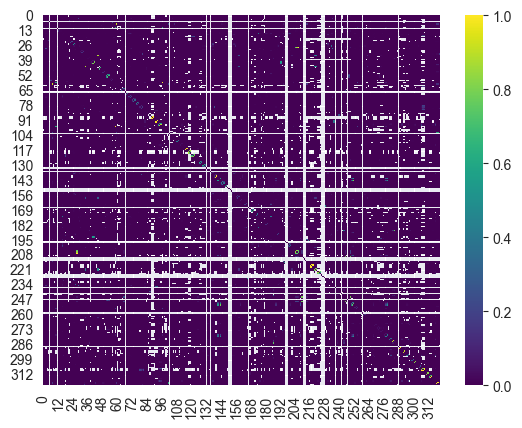

<Figure size 640x480 with 0 Axes>

In [9]:
# Plotting the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

#plt.figure(figure=(100,100))  # fig size
ax = sns.heatmap(r2, cmap='viridis',
            mask=np.isnan(r2),
            )
#sns.set(font_scale=0.8)
ax.set_aspect('auto')

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
plt.savefig("plot.png")


## Calculation for finding Random Match Probability(RAM) *must have MAF

In [83]:
df.head(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,MAF
0,chrY,5690,rs1433259728,T,A,.,PASS,"COMMON;FREQ=dbGaP_PopFreq:0.5563,0.4437;GNO;RS...",0.44370
1,chrY,5733,rs1480643335,G,"A,C",.,PASS,"COMMON;FREQ=GnomAD:0.9656,.,0.03437|dbGaP_PopF...",0.07160
2,chrY,5805,rs1324317743,A,G,.,PASS,"COMMON;FREQ=GnomAD:0.9066,0.09343|dbGaP_PopFre...",0.09004
3,chrY,5807,rs1285314756,T,C,.,PASS,"COMMON;FREQ=GnomAD:0.9107,0.08932|dbGaP_PopFre...",0.08970
4,chrY,5836,rs1188128742,A,"C,G",.,PASS,"COMMON;FREQ=GnomAD:0.2337,0.7663,.|dbGaP_PopFr...",0.26060


In [84]:
df['MajorAF'] = 1 - df['MAF']
df.head(5)[['MajorAF', 'MAF']]

,MajorAF,MAF
0,0.55630,0.44370
1,0.92840,0.07160
2,0.90996,0.09004
3,0.91030,0.08970
4,0.73940,0.26060


In [85]:
df['RMP'] = df['MajorAF']**4 + df['MAF']**4 + (2*df['MajorAF']*df['MAF'])**2
#selected_columns = list(df.columns[:10]) + ['MajorAF', 'RMP'] + list(df.columns[11:len(df.columns)-3])  # TODO: make changes in index values acc. to data
#df = df[selected_columns]
df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,MAF,MajorAF,RMP
0,chrY,5690,rs1433259728,T,A,.,PASS,"COMMON;FREQ=dbGaP_PopFreq:0.5563,0.4437;GNO;RS...",0.44370,0.55630,0.378230
1,chrY,5733,rs1480643335,G,"A,C",.,PASS,"COMMON;FREQ=GnomAD:0.9656,.,0.03437|dbGaP_PopF...",0.07160,0.92840,0.760619
2,chrY,5805,rs1324317743,A,G,.,PASS,"COMMON;FREQ=GnomAD:0.9066,0.09343|dbGaP_PopFre...",0.09004,0.90996,0.712547
3,chrY,5807,rs1285314756,T,C,.,PASS,"COMMON;FREQ=GnomAD:0.9107,0.08932|dbGaP_PopFre...",0.08970,0.91030,0.713389
4,chrY,5836,rs1188128742,A,"C,G",.,PASS,"COMMON;FREQ=GnomAD:0.2337,0.7663,.|dbGaP_PopFr...",0.26060,0.73940,0.452021
...,...,...,...,...,...,...,...,...,...,...,...
19065,chrY,62453165,rs186143557,G,C,.,PASS,"COMMON;FREQ=GnomAD:0.8931,0.1069|Qatari:0.6429...",0.27950,0.72050,0.437804
19066,chrY,62453610,rs12353930,C,"A,G,T",.,PASS,"COMMON;FREQ=GnomAD:0.8287,.,0.1713,.|Qatari:0....",0.07301,0.92699,0.756765
19067,chrY,62453642,rs866751913,T,G,.,PASS,"COMMON;FREQ=GnomAD:0.9956,0.004414|Qatari:0.98...",0.06203,0.93797,0.787582
19068,chrY,62453861,rs1603217837,T,G,.,PASS,"FREQ=SGDP_PRJ:0.5,0.5|dbGaP_PopFreq:0.9944,0;G...",0.99440,0.00560,0.977911


In [86]:
# save as a csv file
df.to_csv(r"D:\genome_asia_main_file\genome_asia_data_working\T2T\T2T_SNP_MAF_0.05_RMP_Microhap.csv", index=False)